In [60]:
import tensorflow as tf;
import tensorflow_datasets as tfds;
import matplotlib;
from matplotlib import pyplot as plt;
import seaborn as sns

# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [61]:
print( tf.__version__ )

2.17.0


In [62]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [63]:
train_data, val_data, test_data = tfds.load( "mnist", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True )

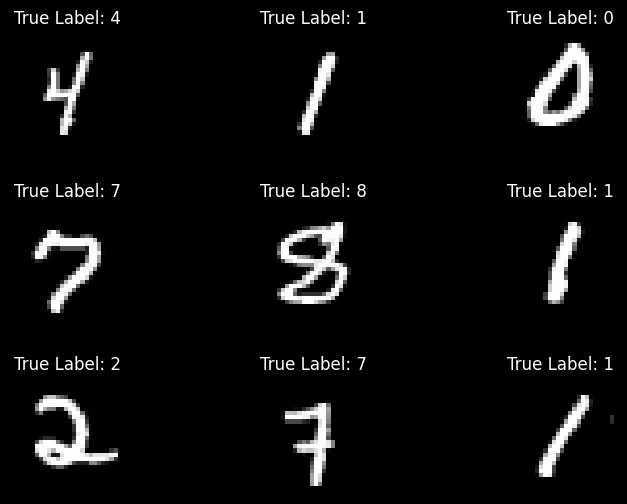

In [64]:
x_viz, y_viz = tfds.load( "mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True )[0]
x_viz = tf.squeeze( x_viz, axis=3 )

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')
    plt.title(f"True Label: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5)

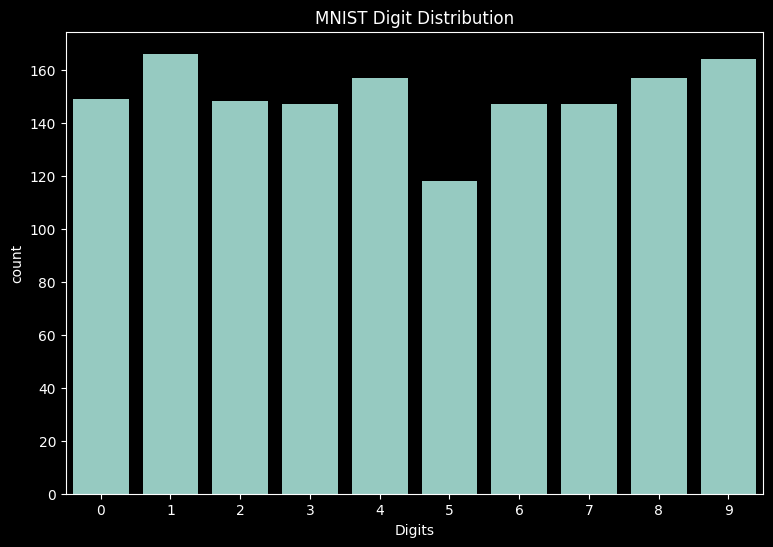

In [65]:
sns.countplot(x=y_viz.numpy());
plt.xlabel('Digits')
plt.title("MNIST Digit Distribution");

In [66]:
def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

In [67]:
def xavier_init( shape ):
  # Computes the xavier initialization values for a weight matrix
  in_dim, out_dim = shape;
  xavier_lim = tf.sqrt( 6. )/tf.sqrt( tf.cast( in_dim + out_dim, tf.float32 ) );
  weight_vals = tf.random.uniform( shape=( in_dim, out_dim ), 
                                  minval=-xavier_lim, maxval=xavier_lim, seed=22 );
  return weight_vals;

In [68]:
class DenseLayer( tf.Module ):
    """
    """
    def __init__( self, out_dim, weight_init=xavier_init, activation=tf.identity ):
        """
        """
        self.out_dim = out_dim;
        self.weight_init = weight_init;
        self.activation = activation;
        self.built = False;

    def __call__( self, x ):
        """
        """
        if not self.built:
            self.in_dim = x.shape[1];
            self.W = tf.Variable( self.weight_init( shape = (self.in_dim, self.out_dim) ) );
            self.b = tf.Variable( tf.zeros( shape = (self.out_dim,) ) );
            self.built = True;

        intermediate = tf.add( tf.matmul ( x, self.W ), self.b );
        return self.activation( intermediate );


In [69]:
class MLP( tf.Module ):
    """
    """
    def __init__( self, layers ):
        """
        """
        self.layers = layers;

    @tf.function
    def __call__( self, x, preds=False ):
        """
        """
        for layer in self.layers:
            x = layer( x );
        return x;

In [70]:
def cross_entropy_loss( y_pred, y ):
    """
    """
    sparse_categorical_crossentropy = tf.nn.sparse_softmax_cross_entropy_with_logits( labels=y, logits=y_pred );
    return tf.reduce_mean( sparse_categorical_crossentropy );

In [71]:
def accuracy( y_pred, y ):
    """
    """
    class_preds = tf.argmax( tf.nn.softmax( y_pred ), axis=1 );
    is_equal = tf.equal( y, class_preds );
    return tf.reduce_mean( tf.cast( is_equal, tf.float32 ) );

In [72]:
class GradientDesent( tf.Module ):
    """
    """
    def __init__( self, learning_rate ):
        """
        """
        self.learning_rate = learning_rate;
        self.title = f"Gradient Descent Optimizer: learning rate = {self.learning_rate}";

    def apply_gradients( self, grads, vars ):
        """
        """
        for grad, var in zip( grads, vars ):
            var.assign_sub( self.learning_rate * grad );

In [73]:
def train_step( x_batch, y_batch, lss, acc, model, optimizer ):
    """
    """
    with tf.GradientTape() as tape:
        y_pred = model( x_batch );
        loss = lss( y_pred, y_batch );
    grads = tape.gradient( loss, model.trainable_variables );
    optimizer.apply_gradients( grads, model.trainable_variables );
    return loss, acc( y_pred, y_batch );

def val_step( x_batch, y_batch, loss, acc, model ):
    """
    """
    y_pred = model( x_batch );
    batch_loss = loss( y_pred, y_batch );
    batch_acc = acc( y_pred, y_batch );
    return batch_loss, batch_acc;

In [74]:
def train_model( mlp, train_data, val_data, loss, acc, optimizer, epochs ):
    train_losses, train_accs = [], [];
    val_losses, val_accs = [], [];

    for epoch in range( epochs ):
        batch_losses_train, batch_accs = [], [];
        batch_losses_val, batch_accs_val = [], [];

        for x_batch, y_batch in train_data:
            batch_loss, batch_acc = train_step( x_batch, y_batch, loss, acc, mlp, optimizer );
            batch_losses_train.append( batch_loss );
            batch_accs.append( batch_acc );

        for x_batch, y_batch in val_data:
            batch_loss, batch_acc = val_step( x_batch, y_batch, loss, acc, mlp );
            batch_losses_val.append( batch_loss );
            batch_accs_val.append( batch_acc );

        # keep track of epoch level model performances
        train_loss, train_acc = tf.reduce_mean( batch_losses_train ), tf.reduce_mean( batch_accs );
        val_loss, val_acc = tf.reduce_mean( batch_losses_val ), tf.reduce_mean( batch_accs_val );
        train_losses.append( train_loss );
        train_accs.append( train_acc );
        val_losses.append( val_loss );
        val_accs.append( val_acc );
        print(f"Epoch: {epoch}" );
        print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}");
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}");
    return train_losses, train_accs, val_losses, val_accs;

In [75]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10
learning_rate = 0.01

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

In [76]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=GradientDesent(learning_rate), epochs=10)

2024-10-05 22:13:28.169194: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-05 22:13:28.675427: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 0
Train Loss: 1.1848664283752441, Train Accuracy: 0.7446051836013794
Validation Loss: 0.5954282879829407, Validation Accuracy: 0.8608583807945251


2024-10-05 22:13:33.761366: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 1
Train Loss: 0.48253825306892395, Train Accuracy: 0.8772099018096924
Validation Loss: 0.40820321440696716, Validation Accuracy: 0.8917128443717957
Epoch: 2
Train Loss: 0.37702471017837524, Train Accuracy: 0.8960598111152649
Validation Loss: 0.34713882207870483, Validation Accuracy: 0.9037777185440063


2024-10-05 22:13:39.671713: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 3
Train Loss: 0.33199501037597656, Train Accuracy: 0.907069206237793
Validation Loss: 0.31373682618141174, Validation Accuracy: 0.910897970199585
Epoch: 4
Train Loss: 0.30398523807525635, Train Accuracy: 0.9143342971801758
Validation Loss: 0.29098302125930786, Validation Accuracy: 0.9164358973503113
Epoch: 5
Train Loss: 0.2834005355834961, Train Accuracy: 0.9198290109634399
Validation Loss: 0.27370336651802063, Validation Accuracy: 0.9214794039726257
Epoch: 6
Train Loss: 0.2668697237968445, Train Accuracy: 0.9244845509529114
Validation Loss: 0.259682297706604, Validation Accuracy: 0.9245451092720032


2024-10-05 22:13:51.501828: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 7
Train Loss: 0.252868115901947, Train Accuracy: 0.9281409978866577
Validation Loss: 0.24779915809631348, Validation Accuracy: 0.9294897317886353
Epoch: 8
Train Loss: 0.24062548577785492, Train Accuracy: 0.9322970509529114
Validation Loss: 0.23741371929645538, Validation Accuracy: 0.9335442781448364
Epoch: 9
Train Loss: 0.22971439361572266, Train Accuracy: 0.9351462721824646
Validation Loss: 0.2282080352306366, Validation Accuracy: 0.9367088675498962


In [77]:
def plot_metrics( train_metric, val_metric, metric_type ):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot( range( len( train_metric ) ), train_metric, label = f"Training {metric_type}" )
  plt.plot( range( len( val_metric ) ), val_metric, label = f"Validation {metric_type}" )
  plt.xlabel( "Epochs" )
  plt.ylabel( metric_type )
  plt.legend()
  plt.title( f"{metric_type} vs Training epochs" );

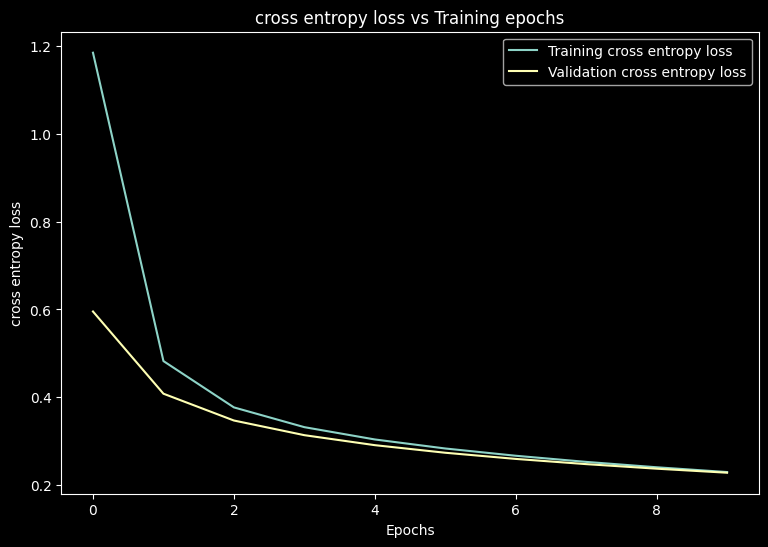

In [78]:
plot_metrics( train_losses, val_losses, "cross entropy loss" )

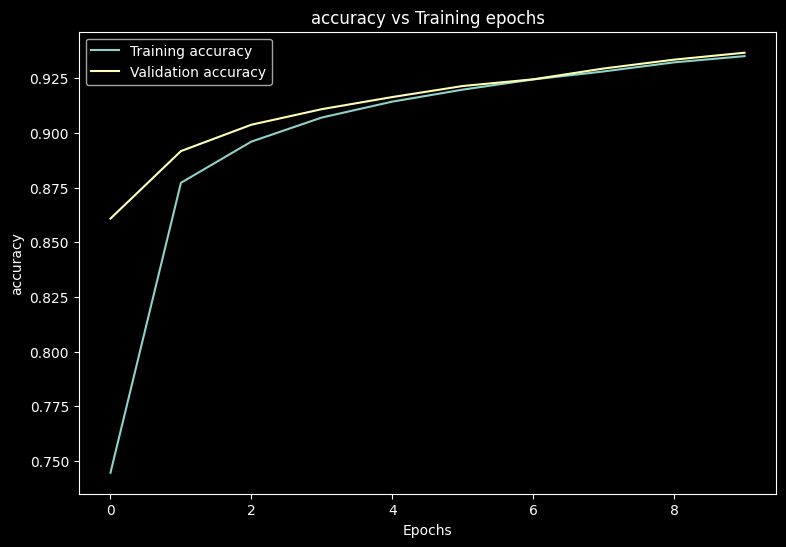

In [79]:
plot_metrics( train_accs, val_accs, "accuracy" )